# Analyze GPT Annotations

In [137]:
%load_ext autoreload
%autoreload 2
from collections import defaultdict
import json
import re

import pandas as pd
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [138]:
anno_filepath = 'output/train_shard_0_sample_results.jsonl'

In [139]:
with open(anno_filepath, 'r') as f:
    annos = [json.loads(line) for line in f]

In [140]:
annos[0]

['M010008RY',
 {'model': 'gpt-3.5-turbo',
  'messages': [{'role': 'system', 'content': 'You are a helpful assistant.'},
   {'role': 'user',
    'content': 'Circumplex theory is a social psychology based theory that characterizes social interactions between speakers. The social orientation tagset includes: {Assured-Dominant, Gregarious-Extraverted, Warm-Agreeable, Unassuming-Ingenuous, Unassured-Submissive, Aloof-Introverted, Cold, Arrogant-Calculating}, which are defined below in more detail.\n\nAssured-Dominant - Demands to be the center of interest, demands attention, does most of the talking, speaks loudly, is firm, is self-confident, is forceful, is ambitious, is assertive, is persistent, is domineering, not self-conscious\n\nGregarious-Extraverted - Feels comfortable around people, starts conversations, talks to a lot of different people, loves large groups, is friendly, is enthusiastic, is warm, is extraverted, is good-natured, is cheerful / happy, is pleasant, is outgoing, is ap

## Data preprocessing
1. Iterate over annos and for each file ID encountered, add it to a dict mapping file ID to a list of results
1. Extract GPT response
1. Write a RegEx to extract the speaker, utterance(s) IDs, label, and explanation
1. Load the source DF and merge
1. Assess how much data we got and how much we're missing

Other tasks:
1. Assess how often the GPT ran out of tokens vs. finishing all annotations and modify prompt length accordingly
1. Prepare next round of data for annotation

### Extract GPT responses

In [141]:
responses = defaultdict(list)
input_output = defaultdict(list)
errors = []
for anno in annos:
    file_id, prompt, response = anno
    if 'choices' not in response:
        errors.append((file_id, prompt, response))
        continue
    generated_content = response['choices'][0]['message']['content']
    # split on newlines (with some lookahead) to handle (e.g. M01000GBL)
    # Speaker 1 (193): Unassuming-Ingenuous - Takes things as they come, Tells the truth, Not self-centered, Is straightforward
    # Explanation: The speaker is stating a fact about themselves.
    split_content = generated_content.split('\n')
    lines = []
    i = 0
    while i < len(split_content):
        line = split_content[i]
        if line == '':
            i += 1
            continue
        if i < len(split_content) - 1:
            lookahead = split_content[i+1]
            if lookahead.startswith('Explanation:'):
                line += '. ' + lookahead
                i += 1
            # elif lookahead == '' and i < len(split_content) - 2:
            #     lookahead = split_content[i+2]
            #     line += '. ' + lookahead
            #     i += 2
        lines.append(line)
        i += 1
    
    responses[file_id].extend(lines)
    input_output[file_id].append((prompt, response))

In [142]:
labels = []
label_obj = defaultdict(list)
for file_id in responses:
    for line in responses[file_id]:
        # apply parser
        label = utils.Label(file_id, line)
        label_obj[file_id].append(label)
        labels.extend(label.data)

In [143]:
# create dataframe
df = pd.DataFrame(labels, columns=['file_id', 'social_orientation', 'utterance_id', 'speaker_id', 'label_str'])

In [144]:
# print(input_output['M01003R61'][-2][0]['messages'][1]['content'])

In [145]:
# print(input_output['M01003R61'][-2][1]['choices'][0]['message']['content'])

In [188]:
# attempt to refine this into JSON or Markdown for better use with GPT
input_1 = """Speaker 1 (1): 在不 (手机QQ可以视频聊天啦! http://mobile.qq.com )
Speaker 2 (2): 在
Speaker 1 (3): 今天和姨妈视频来着，刚知道这些事
Speaker 2 (4): 我很无奈
Speaker 2 (5): 真是不明白，本来他沾光的事情，怎么就成了这样了"""

output_1 = """Speaker 1 (1): Aloof-Introverted - The speaker is sharing a message about a new feature on mobile QQ.
Speaker 2 (2): Unassured-Submissive - The speaker responds with a simple "在" which indicates a lack of confidence or assertiveness.
Speaker 1 (3): Warm-Agreeable - The speaker shares a personal experience with the listener and uses a friendly tone.
Speaker 2 (4): Unassured-Submissive - The speaker expresses a feeling of helplessness.
Speaker 2 (5): Cold - The speaker expresses a lack of understanding and shows no sympathy for the situation."""

input_2 = """Speaker unknown (1): 我前一阵子他前一阵子跟我写信
Speaker unknown (2): 我一阵子碰到你弟弟了
Speaker unknown (3): 是吧
Speaker unknown (4): 嗯
Speaker unknown (5): 我一日没有给我们家写信
Speaker unknown (6): 你知道吗
Speaker unknown (7): 对对他就问我
Speaker unknown (8): 我说我这阵子比较忙
Speaker unknown (9): 我也没有
Speaker unknown (10): 本来我想的那个跟你写个信的
Speaker unknown (11): 但是这边乱糟糟的
Speaker unknown (12): 没办法
Speaker unknown (13): 嗯
Speaker unknown (14): 用不下来
Speaker unknown (15): 一直都是从过春节之后
Speaker unknown (16): 一直到现在一直这样"""

output_2 = """Speaker 1 (1): Unassuming-Ingenuous - The speaker shares a personal experience about receiving a letter from someone.
Speaker 2 (2): Warm-Agreeable - The speaker shares their own experience of meeting the listener's sibling.
Speaker 1 (3): Unassured-Submissive - The speaker responds with a simple "是吧" which indicates a lack of confidence or assertiveness.
Speaker 2 (4): Unassured-Submissive - The speaker responds with a simple "嗯" which indicates a lack of confidence or assertiveness.
Speaker 1 (5): Unassuming-Ingenuous - The speaker admits that they haven't written a letter to their family in a day.
Speaker 1 (6): Warm-Agreeable - The speaker seeks validation from the listener by asking if they know about it.
Speaker 2 (7): Warm-Agreeable - The speaker confirms what the listener asked and mentions that they were asked about it.
Speaker 2 (8): Unassured-Submissive - The speaker explains that they've been busy recently as a reason for not writing a letter.
Speaker 2 (9): Unassured-Submissive - The speaker admits that they also haven't written a letter.
Speaker 2 (10): Warm-Agreeable - The speaker originally planned to write a letter to the listener.
Speaker 2 (11): Unassured-Submissive - The speaker explains that their current situation is chaotic.
Speaker 2 (12): Unassured-Submissive - The speaker expresses a feeling of helplessness with "没办法."
Speaker 1 (13): Unassured-Submissive - The speaker responds with a simple "嗯" which indicates a lack of confidence or assertiveness.
Speaker 2 (14): Unassured-Submissive - The speaker explains that they couldn't find the time to write the letter.
Speaker 2 (15): Unassuming-Ingenuous - The speaker shares that their situation has been like this since the Spring Festival.
Speaker 2 (16): Unassured-Submissive - The speaker reiterates that their situation has been this way until now."""

input_live = """Speaker unknown (1): 喂喂喂还可以啊
Speaker unknown (2): 你去可以能打
Speaker unknown (3): 我就告诉谁说的
Speaker unknown (4): 在网站上说的吗
Speaker unknown (5): 好像看见一个我看见有他那个q a
Speaker unknown (6): 那个部分有一个人就说
Speaker unknown (7): 他说我能够带他
Speaker unknown (8): 我能够带他几个
Speaker unknown (9): 那我不知道
Speaker unknown (10): 他就是他就是问你说如果比如打够15个
Speaker unknown (11): 然后又没有
Speaker unknown (12): 没有就是没接到5个那种外就是外语
Speaker unknown (13): 那个非英语的那个电话
Speaker unknown (14): 然后就再给你机会
Speaker unknown (15): 对他这么说他可以他没在就说
Speaker unknown (16): 专门为了要接那个非英语的单
Speaker unknown (17): 他说你可以继续打
Speaker unknown (18): 好像有这么一说
Speaker unknown (19): 嗯
Speaker unknown (20): 哎那要不算这个就好了
Speaker unknown (21): 然后我第一个不走钻
Speaker unknown (22): 我第一个不是英语说的吗
Speaker unknown (23): 啊有可能很有很有可能会吗
Speaker unknown (24): 我觉得很有可能
Speaker unknown (25): 哎不过就差那么一两块钱
Speaker unknown (26): 哈哈哈哈对你跟他说我第一个作废可以吗
Speaker unknown (27): 然后你说什么
Speaker unknown (28): 你说你跟他讲你说我第一个那个
Speaker unknown (29): 用英语讲那个作废
Speaker unknown (30): 然后保留那个全中文
Speaker unknown (31): 不知道不知道嗯
Speaker unknown (32): 你那你那细胞怎么回事啊
Speaker unknown (33): 你你那个在你身边吗
Speaker unknown (34): 在在我先拿着呢啊
Speaker unknown (35): 嗯
Speaker unknown (36): 说啊哎我以为你在准备的好
Speaker unknown (37): 第一个扣是就是part one的一个最上面是不是要填2006啊
Speaker unknown (38): 嗯嗯嗯
Speaker unknown (39): 然后名字那个你说第二个空天那个对
Speaker unknown (40): 第二个就是对对对对
Speaker unknown (41): 然后地址
Speaker unknown (42): 嗯
Speaker unknown (43): 这都没问题
Speaker unknown (44): 你看那个9a
Speaker unknown (45): 9a啊那个car
Speaker unknown (46): carman
Speaker unknown (47): immigrant state
Speaker unknown (48): 嗯
Speaker unknown (49): 我就是iphone啊你是什么
Speaker unknown (50): 就跟跟那个签证一样啊就写成了对啊对啊就是你签证类型
Speaker unknown (51): 我写的student
Speaker unknown (52): 就写f1的
Speaker unknown (53): 好像不应该写student的吧
Speaker unknown (54): 对啊对我刚开始是我就是看他那写的我就想啊是不是写学生
Speaker unknown (55): 你看他那个我看他那个instruction上写的好像要写你的对可能是要写钱对对就是跟第六个我觉得又重了我就不是明白
Speaker unknown (56): 第六个是什么好吧
Speaker unknown (57): 第六个就问你签证类啊第六个我姐姐也是iPhone
Speaker unknown (58): 嗯我就写两个iPhone是吧
Speaker unknown (59): 对对哎真是好我还真是没什么意思
Speaker unknown (60): 对啊为什么要重呢
Speaker unknown (61): 然后
Speaker unknown (62): 然后这个9b是ds
Speaker unknown (63): 10呢
Speaker unknown (64): 就是10是应该是画那个check号是吧
Speaker unknown (65): 10是check啊
Speaker unknown (66): 对啊
Speaker unknown (67): 他下边哪个9你刚问我哪个了
Speaker unknown (68): b9b9b是应该写ds
Speaker unknown (69): ds什么叫ds
Speaker unknown (70): during of status
Speaker unknown (71): 9b啊就是那个"""

In [189]:
def extract_input_utterances(input):
    # second element is the speaker id, third element is the utterance id
    utterances = []
    for line in input.split('\n'):
        spaces_split = line.split(' ')
        text = line.split(': ')[1]
        utterance_id = int(spaces_split[2][1:-2])
        speaker_id = spaces_split[1] if spaces_split[1] == 'unknown' else int(spaces_split[1])
        utterances.append((utterance_id, speaker_id, text))
    utterances_df = pd.DataFrame(utterances, columns=['Utterance ID', 'Speaker ID', 'Text'])
    return utterances_df

In [190]:
input_1_df = extract_input_utterances(input_1)
input_2_df = extract_input_utterances(input_2)
input_live_df = extract_input_utterances(input_live)

In [191]:
# remove excess spaces
print(input_1_df.to_markdown(index=False, tablefmt='github'))
print(input_2_df.to_markdown(index=False, tablefmt='github'))
print(input_live_df.to_markdown(index=False, tablefmt='github'))

|   Utterance ID |   Speaker ID | Text                                               |
|----------------|--------------|----------------------------------------------------|
|              1 |            1 | 在不 (手机QQ可以视频聊天啦! http://mobile.qq.com ) |
|              2 |            2 | 在                                                 |
|              3 |            1 | 今天和姨妈视频来着，刚知道这些事                   |
|              4 |            2 | 我很无奈                                           |
|              5 |            2 | 真是不明白，本来他沾光的事情，怎么就成了这样了     |
|   Utterance ID | Speaker ID   | Text                         |
|----------------|--------------|------------------------------|
|              1 | unknown      | 我前一阵子他前一阵子跟我写信 |
|              2 | unknown      | 我一阵子碰到你弟弟了         |
|              3 | unknown      | 是吧                         |
|              4 | unknown      | 嗯                           |
|              5 | unknown      | 我一日没有给我们家写信       |
|              6 | unknown   

In [192]:
def extract_output_utterances(output):
    # second element is the speaker id, third element is the utterance id
    utterances = []
    for line in output.split('\n'):
        spaces_split = line.split(' ')
        text = line.split(': ')[1]
        label = text.split(' - ')[0]
        explanation = text.split(' - ')[1]
        utterance_id = int(spaces_split[2][1:-2])
        speaker_id = spaces_split[1] if spaces_split[1] == 'unknown' else int(spaces_split[1])
        utterances.append((utterance_id, speaker_id, label, explanation))
    utterances_df = pd.DataFrame(utterances, columns=['Utterance ID', 'Speaker ID', 'Label', 'Explanation'])
    return utterances_df

In [193]:
output_1_df = extract_output_utterances(output_1)
output_2_df = extract_output_utterances(output_2)

In [195]:
# reconstruct the prompt
preamble = input_output['M010008RY'][0][0]['messages'][1]['content'].split('Input:\n')[0]
no_speaker_preamble = "It's also possible that a speaker number is unknown for an utterance, in which case you should assign speaker numbers to the utterances. Many conversations will have 2 speakers but some will have 3 or more. For example, here is the expected input and output format for such a conversation.\n\n"

In [200]:
def pandas_to_markdown(df):
    """Converts each row of a pandas dataframe to markdown delimited by | with a single space on each side.
    There is also a row of dashes between the header and the table body.
    """
    header = '| ' + ' | '.join(df.columns) + ' |'
    dashes = '| ' + ' | '.join(['---' for _ in df.columns]) + ' |'
    data = '\n'.join(['| ' + ' | '.join([str(x) for x in row]) + ' |' for row in df.values])
    return '\n'.join([header, dashes, data])

In [201]:
print(pandas_to_markdown(input_1_df))

| Utterance ID | Speaker ID | Text |
| --- | --- | --- |
| 1 | 1 | 在不 (手机QQ可以视频聊天啦! http://mobile.qq.com ) |
| 2 | 2 | 在 |
| 3 | 1 | 今天和姨妈视频来着，刚知道这些事 |
| 4 | 2 | 我很无奈 |
| 5 | 2 | 真是不明白，本来他沾光的事情，怎么就成了这样了 |


In [202]:
print(preamble + 'Input:\n' + pandas_to_markdown(input_1_df) + '\n\nOutput:\n' + pandas_to_markdown(output_1_df) + '\n---\n' + no_speaker_preamble
      + 'Input:\n' + pandas_to_markdown(input_2_df) + '\n\nOutput:\n' + pandas_to_markdown(output_2_df) + '\n---\n'
      + 'Input:\n' + pandas_to_markdown(input_live_df) + '\n\nOutput:\n')

Circumplex theory is a social psychology based theory that characterizes social interactions between speakers. The social orientation tagset includes: {Assured-Dominant, Gregarious-Extraverted, Warm-Agreeable, Unassuming-Ingenuous, Unassured-Submissive, Aloof-Introverted, Cold, Arrogant-Calculating}, which are defined below in more detail.

Assured-Dominant - Demands to be the center of interest, demands attention, does most of the talking, speaks loudly, is firm, is self-confident, is forceful, is ambitious, is assertive, is persistent, is domineering, not self-conscious

Gregarious-Extraverted - Feels comfortable around people, starts conversations, talks to a lot of different people, loves large groups, is friendly, is enthusiastic, is warm, is extraverted, is good-natured, is cheerful / happy, is pleasant, is outgoing, is approachable, is not shy, is "lively"

Warm-Agreeable - is interested in people, reassures others, inquires about others' well-being, gets along well with others,

In [187]:
print(input_output['M010008RY'][0][0]['messages'][1]['content'])

Circumplex theory is a social psychology based theory that characterizes social interactions between speakers. The social orientation tagset includes: {Assured-Dominant, Gregarious-Extraverted, Warm-Agreeable, Unassuming-Ingenuous, Unassured-Submissive, Aloof-Introverted, Cold, Arrogant-Calculating}, which are defined below in more detail.

Assured-Dominant - Demands to be the center of interest, demands attention, does most of the talking, speaks loudly, is firm, is self-confident, is forceful, is ambitious, is assertive, is persistent, is domineering, not self-conscious

Gregarious-Extraverted - Feels comfortable around people, starts conversations, talks to a lot of different people, loves large groups, is friendly, is enthusiastic, is warm, is extraverted, is good-natured, is cheerful / happy, is pleasant, is outgoing, is approachable, is not shy, is "lively"

Warm-Agreeable - is interested in people, reassures others, inquires about others' well-being, gets along well with others,

In [179]:
print(input_output['M010008RY'][0][1]['choices'][0]['message']['content'])

Speaker 1 (1): Aloof-Introverted - The speaker answers the phone with a simple greeting.
Speaker 2 (2): Unassured-Submissive - The speaker responds with a suggestion that lacks confidence.
Speaker 1 (3): Unassured-Submissive - The speaker responds with a simple "我就告诉谁说的" which indicates a lack of confidence or assertiveness.
Speaker 2 (4): Aloof-Introverted - The speaker responds with a question that lacks enthusiasm.
Speaker 2 (5): Cold - The speaker expresses a lack of understanding and shows no sympathy for the situation.
Speaker 1 (6): Aloof-Introverted - The speaker responds with a statement lacking enthusiasm or emotion.
Speaker 2 (7): Assured-Dominant - The speaker confirms what the listener asked and mentions that they were asked about it.
Speaker 2 (8): Assured-Dominant - The speaker asserts themselves with "我能够带他几个" and shows confidence.
Speaker 2 (9): Unassured-Submissive - The speaker expresses uncertainty with "那我不知道."
Speaker 2 (10): Assured-Dominant - The speaker asserts

In [170]:
print(input_output['M010008RY'][-2][0]['messages'][1]['content'])

Circumplex theory is a social psychology based theory that characterizes social interactions between speakers. The social orientation tagset includes: {Assured-Dominant, Gregarious-Extraverted, Warm-Agreeable, Unassuming-Ingenuous, Unassured-Submissive, Aloof-Introverted, Cold, Arrogant-Calculating}, which are defined below in more detail.

Assured-Dominant - Demands to be the center of interest, demands attention, does most of the talking, speaks loudly, is firm, is self-confident, is forceful, is ambitious, is assertive, is persistent, is domineering, not self-conscious

Gregarious-Extraverted - Feels comfortable around people, starts conversations, talks to a lot of different people, loves large groups, is friendly, is enthusiastic, is warm, is extraverted, is good-natured, is cheerful / happy, is pleasant, is outgoing, is approachable, is not shy, is "lively"

Warm-Agreeable - is interested in people, reassures others, inquires about others' well-being, gets along well with others,

In [167]:
df[df['file_id'] == 'M010008RY'].iloc[50:55]['label_str'].values[0]

'Speaker unknown (19-61): The speaker tags for these utterances are not provided.'

In [161]:
df.sample(20)

,file_id,social_orientation,utterance_id,speaker_id,label_str
542,M01004WNG,Unassured-Submissive,73.0,1.0,Speaker 1 (73): Unassured-Submissive - The spe...
782,M01004WNG,Warm-Agreeable,154.0,1.0,Speaker 1 (154): Warm-Agreeable - The speaker ...
500,M01004WNG,Aloof-Introverted,818.0,1.0,Speaker 1 (818): Aloof-Introverted - The speak...
954,M01004WNG,Warm-Agreeable,560.0,1.0,Speaker 1 (560): Warm-Agreeable - The speaker ...
461,M01004WNG,Warm-Agreeable,290.0,1.0,Speaker 1 (290): Warm-Agreeable - The speaker ...
615,M01004WNG,Warm-Agreeable,470.0,1.0,Speaker 1 (470): Warm-Agreeable - The speaker ...
842,M01004WNG,Unassured-Submissive,721.0,1.0,Speaker 1 (721): Unassured-Submissive - The sp...
52,M010008RY,None,53.0,NaN,Speaker unknown (19-61): The speaker tags for ...
962,M01004WNG,Warm-Agreeable,568.0,1.0,Speaker 1 (568): Warm-Agreeable - The speaker ...
831,M01004WNG,Warm-Agreeable,710.0,1.0,Speaker 1 (710): Warm-Agreeable - The speaker ...


In [58]:
df[df['file_id'] == 'M01003R61'].sort_values('utterance_id').head(10)

,file_id,social_orientation,utterance_id,speaker_id,label_str
53,M01003R61,Arrogant-Calculating,1.0,8,Speaker 8 (1): Arrogant-Calculating - The spea...
4,M01003R61,Gregarious-Extraverted,1.0,72,Speaker 72 (1): Gregarious-Extraverted - The s...
69,M01003R61,Gregarious-Extraverted,1.0,58,Speaker 58 (1): Gregarious-Extraverted - The s...
174,M01003R61,Gregarious-Extraverted,1.0,1,Speaker 1 (1): Gregarious-Extraverted - The sp...
175,M01003R61,Unassuming-Ingenuous,2.0,2,Speaker 2 (2): Unassuming-Ingenuous - The spea...
5,M01003R61,Unassured-Submissive,2.0,73,Speaker 73 (2): Unassured-Submissive - The spe...
70,M01003R61,Unassured-Submissive,2.0,58,Speaker 58 (2): Unassured-Submissive - The spe...
54,M01003R61,Warm-Agreeable,2.0,9,Speaker 9 (2): Warm-Agreeable - The speaker re...
176,M01003R61,Warm-Agreeable,3.0,3,Speaker 3 (3): Warm-Agreeable - The speaker gr...
71,M01003R61,Unassuming-Ingenuous,3.0,58,Speaker 58 (3): Unassuming-Ingenuous - The spe...


In [37]:
len(df)

21451

## Load source dataframe and merge

In [227]:
source_filepath = '~/Documents/data/charm/transformed/circumplex/gpt_prompts_r1_mini_eval_text.csv'
source_df = pd.read_csv(source_filepath)

In [228]:
source_df.head()

,filename,@id,@start_char,@end_char,ORIGINAL_TEXT,@type,@begin_offset,@char_length,id,time,...,TOKEN,social_orientation_random,file_id,timestamp,impact_scalar,comment,Utterance ID,Complete Line,Complete Line Length,line_len_cumsum
0,M01000EY0.ltf.xml,segment-0,0,11,你手机充300不够是吧？,message,0,14,m0000,2012-07-09 08:54:39 UTC,...,"[{'@id': 'token-0-0', '@pos': 'word', '@morph'...",Cold,M01000EY0,NaN,NaN,NaN,1,Speaker 1 (1): 你手机充300不够是吧？,20,20
1,M01000EY0.ltf.xml,segment-1,14,20,115.51？,message,14,9,m0001,2012-07-09 08:56:50 UTC,...,"[{'@id': 'token-1-0', '@pos': 'word', '@morph'...",Warm-Agreeable,M01000EY0,NaN,NaN,NaN,2,Speaker 2 (2): 115.51？,12,32
2,M01000EY0.ltf.xml,segment-2,23,27,我都糊涂了,message,23,7,m0002,2012-07-09 08:56:53 UTC,...,"[{'@id': 'token-2-0', '@pos': 'word', '@morph'...",Arrogant-Calculating,M01000EY0,NaN,NaN,NaN,3,Speaker 2 (3): 我都糊涂了,16,48
3,M01000EY0.ltf.xml,segment-3,30,36,我打电话问问吧,message,30,9,m0003,2012-07-09 08:56:59 UTC,...,"[{'@id': 'token-3-0', '@pos': 'word', '@morph'...",Cold,M01000EY0,NaN,NaN,NaN,4,Speaker 2 (4): 我打电话问问吧,15,63
4,M01000EY0.ltf.xml,segment-4,39,39,昂,message,39,3,m0004,2012-07-09 08:57:56 UTC,...,"{'@id': 'token-4-0', '@pos': 'word', '@morph':...",Cold,M01000EY0,NaN,NaN,NaN,5,Speaker 1 (5): 昂,9,72


In [229]:
# join with the source_df where file_id == file_id, Utterance ID == utterance_id, participant == speaker_id
merge_df = source_df.merge(df, left_on=['file_id', 'Utterance ID', 'participant'], right_on=['file_id', 'utterance_id', 'speaker_id'], how='left')

In [231]:
len(merge_df)

34570

In [230]:
len(source_df)

34558

In [234]:
# in some instances, the model is labeling an utterance twice with the same utterance ID and same participant
# can probably safely drop duplicates when the social orientation is the same
# merge_df[merge_df.duplicated(subset=['file_id', 'Utterance ID', 'participant'], keep=False)]

In [236]:
merge_df = merge_df.drop_duplicates(subset=['file_id', 'Utterance ID', 'participant', 'social_orientation'], keep='first')

In [238]:
# simply drop ALL the remaining duplicates to avoid any issues
merge_df = merge_df.drop_duplicates(subset=['file_id', 'Utterance ID', 'participant'], keep=False,)

In [248]:
# drop any rows that are missing data
merge_df = merge_df.dropna(subset=['social_orientation', 'utterance_id', 'speaker_id'])

<Axes: >

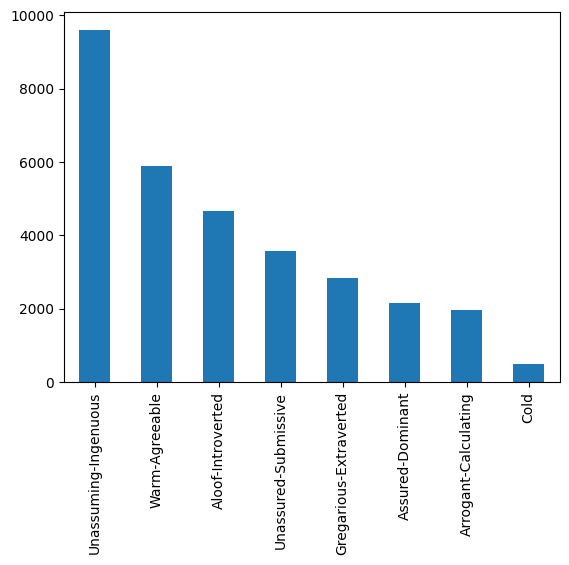

In [254]:
merge_df['social_orientation'].value_counts().plot(kind='bar')

In [ ]:
# save to file
dest_filepath = '~/Documents/data/charm/transformed/circumplex/gpt_labels_r1_mini_eval_text.csv'
merge_df.to_csv(dest_filepath, index=False)

In [257]:
merge_df['file_id'].nunique() * 0.8

248.8

## Error Analysis

**No utterance ID, speaker identifier, and/or social orientation tag**
- M01000F8S, Social orientation tag: Unassuming-Ingenuous
- M01000FCG, Overall, the conversation is characterized by a lack of assertiveness and a tendency towards introversion and self-doubt. Both speakers express dissatisfaction with their current situation and a desire for a romantic relationship, but Speaker 2 seems to be more focused on their high standards and reluctance to actively pursue a relationship.
M01000FK3, Social orientation tag: Unassured-Submissive
- M01000GBL, Speaker 2 (253): N/A. Explanation: The speaker is expressing a non-verbal emotion.

**Model attributes overlapping ranges of utterances to different speakers, resulting in multiple social orientation tags**
- M01000FCG, Speaker 1 (1-10): Unassured-Submissive. Speaker 1 expresses frustration and dissatisfaction with their job and their inability to take a nap during the day. They also mention being forgetful and not having done much at work. They seem to lack confidence and are not forceful in their speech.
- M01000FCG, Speaker 2 (5-35): Aloof-Introverted. Speaker 2 is reserved and not very talkative. They express disinterest in going to a singles party and describe the men there as nerdy and desperate. They also express their high standards for a partner and their reluctance to actively pursue a relationship. They seem to be focused inward and not very social.

**Model uses inconsistent formatting**
- Uses ranges of utterance ids (e.g. 20-30) (solved)
- Uses range of utterance ids (63, 66-83, 86-107) (M01000GND)
- Uses periods instead of parentheses (e.g. 42.) (solved)
- The model puts the explanation on the following line, follow 2 lines, or even following 3 lines (e.g. M01000GNZ, )
    - e.g. M01000GBL
    - Speaker 2 (253): N/A
    - Explanation: The speaker is expressing a non-verbal emotion.
    - e.g. M01000GQ4
    - Speaker 3 (54):  我同意，我们需要找到一个解决方案。
    - Social orientation tag: Warm-Agreeable
    - Explanation: Speaker 3 is agreeing with Speaker 2
- General statement about the conversation, unrelated to any single utterance (may not need to be solved) (e.g. M01000GE2)
    - Overall, the conversation is characterized by a warm and friendly tone, with both speakers showing concern for each other's well-being and offering support and advice.
- Some prompts only contain a single utterance, resulting in a malformed response (this should be solvable)
    - e.g. M01000GEL Speaker 1 (47):  好的呢
    - e.g. M01000GJ5 Speaker 2 (58):  [图片]

TODO: continue analyzing errors from index 40 onwards

In [213]:
df.sample(n=2)

,file_id,social_orientation,utterance_id,speaker_id,label_str
17858,M01000GNU,Warm-Agreeable,35.0,1.0,Speaker 1 (35): Warm-Agreeable - The speaker e...
25527,M01000GX3,Unassured-Submissive,30.0,2.0,Speaker 2 (30): Unassured-Submissive - The spe...


In [219]:
# df[df['utterance_id'].isna()].iloc[35:40]
# file_id = 'M01000GNU'
# label_obj[file_id][0]

# print(input_output[file_id][1][1]['choices'][0]['message']['content'])
# print(input_output[file_id][1][0]['messages'][1]['content'])#[1]['choices'][0]['message']['content'])
# idx = 0
# for prompt, response in input_output[file_id]:
#     print(idx)
#     print(response['choices'][0]['message']['content'])
#     idx+=1